In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import tensorflow as tf
import keras
from keras.optimizers import Adam
import cv2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from PIL import Image
from copy import deepcopy
import tqdm
import math, random

sys.path.append('../src')

from data_loading import load_datasets_singleduration
from util import get_model_by_name, create_losses

from losses_keras2 import *
from sal_imp_utilities import *
from cb import InteractivePlot

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

%load_ext autoreload
%autoreload 2

/netpool/homes/wangyo/.conda/envs/tf-cuda9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/netpool/homes/wangyo/.conda/envs/tf-cuda9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/netpool/homes/wangyo/.conda/envs/tf-cuda9/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/netpool/homes/wangyo/

# Check GPU status

In [2]:
%%bash
nvidia-smi

Sat Nov 26 14:29:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:29:00.0  On |                  N/A |
| 29%   39C    P2    37W / 184W |   1553MiB /  7959MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]

'0'

# Load data

In [4]:
# FILL THESE IN 
bp = "/netpool/homes/wangyo/Dataset/"

dataset_imp = "imp1k"
dataset_sal = "UMSI_SALICON"

In [5]:
data_imp = load_datasets_singleduration(dataset_imp, bp)

Using imp1k
Length of loaded files:
train images: 798
train maps: 798
val images: 200
val maps: 200


In [6]:
data_sal = load_datasets_singleduration(dataset_sal, bp)

Using SALICON (no fixation coords)
Length of loaded files:
train images: 10000
train maps: 10000
val images: 5000
val maps: 5000
test images 5000
Length of loaded files:
train images: 10000
train maps: 10000
val images: 5000
val maps: 5000


# Model and training params

In [7]:
ckpt_savedir = "ckpt"

# FILL THESE IN: set training parameters
# If you want to resume from previous training, set load_weights = True
load_weights = False
weightspath = "./ckpt/weights.hdf5"

batch_size = 
init_lr = 
lr_reduce_by = 
reduce_at_epoch = 
n_epochs = 

opt = 

model_name = "UMSI"
model_inp_size = (, )
model_out_size = (, )

In [8]:
input_shape = model_inp_size + (3,)

In [9]:
# get model 
model_params = {
    'input_shape': input_shape,
    'n_outs': 2
}
model_func, mode = get_model_by_name(model_name)
model = model_func(**model_params)

if load_weights: 
    model.load_weights(weightspath)
    print("load")


xception output shapes: (?, 30, 40, 2048)
(?, 480, 640, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 119, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 119, 159, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 119, 159, 32) 0           block1_conv1_bn[0][0]            
________________________________

In [10]:
# set up data generation and checkpoints
if not os.path.exists(ckpt_savedir): 
    os.makedirs(ckpt_savedir)

# Generators
gen_train = ImpAndClassifGenerator(
        img_filenames=data_imp[0],
        imp_filenames=data_imp[1],
        fix_filenames=None,
        extra_imgs=data_sal[0], # For feeding a much larger dataset, e.g. salicon, that the generator will subsample to maintain class balance
        extra_imps=data_sal[1],
        extra_fixs=None,
        extras_per_epoch=160,
        batch_size=4,
        img_size=(shape_r,shape_c),
        map_size=(shape_r_out, shape_c_out),
        shuffle=True,
        augment=False,
        n_output_maps=1,
        concat_fix_and_maps=False,
        fix_as_mat=False,
        fix_key="",
        str2label=None,
        dummy_labels=False,
        num_classes=6,
        pad_imgs=True,
        pad_maps=True,
        return_names=False,
        return_labels=True,
        read_npy=False)

gen_val = ImpAndClassifGenerator(
            img_filenames=data_imp[3], 
            imp_filenames=data_imp[4], 
            fix_filenames=None, 
            extra_imgs=data_sal[3], # For feeding a much larger dataset, e.g. salicon, that the generator will subsample to maintain class balance
            extra_imps=data_sal[4],
            extra_fixs=None,
            extras_per_epoch=40,
            batch_size=1, 
            img_size=(shape_r,shape_c), 
            map_size=(shape_r_out, shape_c_out),
            shuffle=False, 
            augment=False, 
            str2label=None,
            dummy_labels=False,
            #n_output_maps=1,
        )

# Callbacks

# where to save checkpoints
filepath = os.path.join(ckpt_savedir, dataset_imp + '_kl+cc+bin_ep{epoch:02d}_valloss{val_loss:.4f}.hdf5')

print("Checkpoints will be saved with format %s" % filepath)

cb_chk = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=True, period=1)
cb_plot = InteractivePlot()

def step_decay(epoch):
    lrate = init_lr * math.pow(lr_reduce_by, math.floor((1+epoch)/reduce_at_epoch))
    if epoch%reduce_at_epoch:
        print('Reducing lr. New lr is:', lrate)
    return lrate
cb_sched = LearningRateScheduler(step_decay)

cbs = [cb_chk, cb_sched, cb_plot]

Instantiating ImpAndClassifGenerator. Number of files received: 798. Extras: 10000. Batch size: 4. Image size: (240, 320). Map size: (480, 640). Augmentation: 0, Pad_imgs: True. Pad_maps: True. Num classes: 6.
Instantiating ImpAndClassifGenerator. Number of files received: 200. Extras: 5000. Batch size: 1. Image size: (240, 320). Map size: (480, 640). Augmentation: 0, Pad_imgs: True. Pad_maps: True. Num classes: 6.
Checkpoints will be saved with format ckpt/imp1k_kl+cc+bin_ep{epoch:02d}_valloss{val_loss:.4f}.hdf5


In [11]:
#test the generator 
img, outs = gen_train.__getitem__(1)
print("batch size: %d. Num inputs: %d. Num outputs: %d." % (batch_size, len(img), len(outs)))
print(outs[0].shape)
print(outs[1].shape)

batch size: 4. Num inputs: 4. Num outputs: 2.
(4, 480, 640, 1)
(4, 6)


# Train

In [12]:
model.compile(optimizer=opt, loss={'dec_c_cout': kl_cc_combined, "out_classif":"binary_crossentropy"}, loss_weights={'dec_c_cout': 1, "out_classif":5})

print('Ready to train')
model.fit_generator(gen_train, epochs=n_epochs, verbose=1, callbacks=cbs, validation_data=gen_val, max_queue_size=10, workers=5)

k= Tensor("loss/dec_c_cout_loss/kl_cc_combined/kullback_leibler_divergence/weighted_loss/value:0", shape=(), dtype=float32)
c= Tensor("loss/dec_c_cout_loss/kl_cc_combined/truediv_9:0", shape=(?, ?), dtype=float32)
Ready to train
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/15
  2/240 [..............................] - ETA: 34:59 - loss: 2.0819 - dec_c_cout_loss: -0.4818 - out_classif_loss: 0.5127

KeyboardInterrupt: 

## Some visualizations

In [11]:
if True: 
    W = "./ckpt/weights.hdf5"
    model.load_weights(W)
    print('load')

load


In [10]:
# Visualize some output on the val set 
gen = UMSI_eval_generator(
    data_sal[3], 
    data_sal[4], 
    inp_size=model_inp_size)

examples = [next(gen) for _ in range(50)]
len(examples)

50

maps size 1 (480, 640)


Text(0.5, 1.0, 'Prediction')

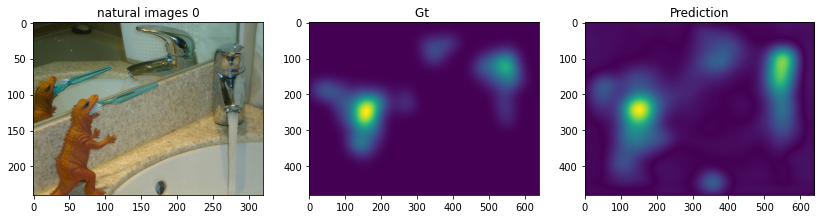

In [15]:
for example in examples[4:]:
    images, maps, img_filename_= example
    preds = model.predict(images[0])
    preds_map = preds[0]
    preds_classif = preds[1]
    break


print("maps size", len(maps), maps[0].shape)
batch = 0

plt.figure(figsize = (14,8))
plt.subplot(1,3,1)
plt.imshow(reverse_preprocess(np.squeeze(images[0])))

plt.title("natural images %d" % batch)


plt.subplot(1,3,2)
plt.imshow(maps[0])
plt.title('Gt ' )

plt.subplot(1,3,3)
plt.imshow(postprocess_predictions(np.squeeze(preds_map[0]),maps[0].shape[0],maps[0].shape[1], zero_to_255=True))
plt.title('Prediction')


maps size 1 (600, 403)
[[6.0552056e-03 1.0883468e-03 1.7824194e-04 9.9062890e-01 3.8274837e-04
  1.6666814e-03]]


Text(0.5, 1.0, 'Prediction')

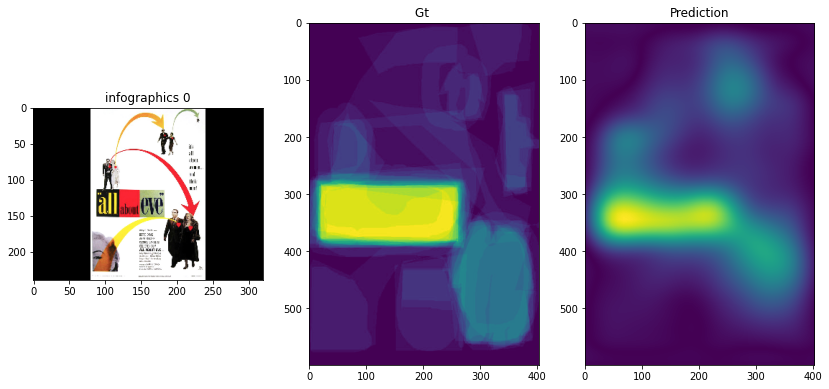

In [50]:
images, maps, img_filename= random.choice(examples)

print("maps size", len(maps), maps[0].shape)
batch = 0
preds = model.predict(images[0])
preds_map = preds[0]
preds_classif = preds[1]
cl = np.argmax(preds_classif)
print(preds_classif)
plt.figure(figsize = (14,8))
plt.subplot(1,3,1)
plt.imshow(reverse_preprocess(np.squeeze(images[0])))
if(cl==0):
    plt.title("advertisment %d" % batch)
if(cl==1):
    plt.title("infographic %d" % batch)
if(cl==2):
    plt.title("movie_posters %d" % batch)
if(cl==3):
    plt.title("infographics %d" % batch)
if(cl==4):
    plt.title("webpages %d" % batch)

plt.subplot(1,3,2)
plt.imshow(maps[0])
plt.title('Gt ' )

plt.subplot(1,3,3)
    # print("preds time sahpe", preds[time].shape)
plt.imshow(postprocess_predictions(np.squeeze(preds_map[0]),maps[0].shape[0],maps[0].shape[1], zero_to_255=True))
plt.title('Prediction')


maps size 1 (419, 600)
[[1.6331922e-02 9.6636081e-01 3.2052523e-04 1.4160827e-04 1.6243869e-02
  6.0123758e-04]]


Text(0.5, 1.0, 'Prediction')

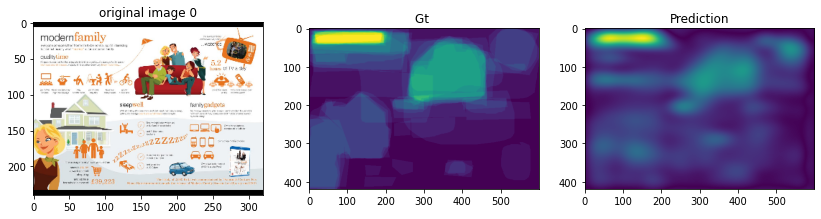

In [34]:
images, maps, img_filename= random.choice(examples)

print("maps size", len(maps), maps[0].shape)
batch = 0
preds = model.predict(images[0])
preds_map = preds[0]
preds_classif = preds[1]
print(preds_classif)
plt.figure(figsize = (14,8))
plt.subplot(1,3,1)
plt.imshow(reverse_preprocess(np.squeeze(images[0])))
plt.title("original image %d" % batch)

plt.subplot(1,3,2)
plt.imshow(maps[0])
plt.title('Gt ' )

plt.subplot(1,3,3)
    # print("preds time sahpe", preds[time].shape)
plt.imshow(postprocess_predictions(np.squeeze(preds_map[0]),maps[0].shape[0],maps[0].shape[1], zero_to_255=True))
plt.title('Prediction')


# Evaluate

In [7]:
W = "./ckpt/imp1k_kl+cc+bin_ep13_valloss-2.4641.hdf5"
model.load_weights(W)
print("load weights")

load


In [69]:
def predict_and_save(model, test_img, inp_size, savedir, mode='multistream_concat', blur=False, test_img_base_path="", ext="png"):
    # if test_img_base_path is specified, then preserves the original
    # nested structure of the directory from which the stuff is pulled
    c=0
    if blur:
        print('BLURRING PREDICTIONS')
        if 'blur' not in savedir:
            savedir = savedir+'_blur'
    else:
        print('NOT BLURRING PREDICTIONS')
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    for imfile in tqdm.tqdm(test_img):
        batch = 0
        time = 0
        map_idx = 0
        gt_shape = Image.open(imfile).size[::-1]
        img = preprocess_images([imfile], inp_size[0], inp_size[1])
        preds = model.predict(img)
        if mode == 'multistream_concat':
            p = preds[time][batch][map_idx][:, :, 0]
        elif mode == 'simple':
            p = preds[0][batch][:,:,0]
        elif mode == 'singlestream':
            p = preds[0][batch][time][:,:,0]
        else:
            raise ValueError('Unknown mode')
        p = postprocess_predictions(p, gt_shape[0], gt_shape[1], blur, normalize=False, zero_to_255=True)
        p_norm = (p-np.min(p))/(np.max(p)-np.min(p))
        p_img = p_norm*255
        hm_img = Image.fromarray(np.uint8(p_img), "L")
        print("heatmap shape", p_img.shape)

        imname = os.path.splitext(os.path.basename(imfile))[0] + "." + ext
        if test_img_base_path:
            relpath = os.path.dirname(imfile).replace(test_img_base_path, "")
            relpath = os.path.join(savedir, relpath)
            if not os.path.exists(relpath):
                os.makedirs(relpath)
            savepath = os.path.join(relpath, imname)
        else:
            savepath = os.path.join(savedir, imname)
        hm_img.save(savepath)

In [70]:
savedir = "../pred/UMSI/result/"
predict_and_save(model, data_imp[3], inp_size=(shape_r, shape_c), savedir=savedir, mode='simple', blur=False, test_img_base_path="", ext="png")


  0%|          | 0/200 [00:00<?, ?it/s]

NOT BLURRING PREDICTIONS
heatmap shape (900, 640)
heatmap shape (1615, 1750)


  2%|▏         | 3/200 [00:00<00:32,  6.14it/s]

heatmap shape (1263, 2587)
heatmap shape (581, 1024)



  2%|▎         | 5/200 [00:00<00:28,  6.76it/s]

heatmap shape (2160, 970)
heatmap shape (852, 600)



  4%|▎         | 7/200 [00:00<00:24,  7.90it/s]

heatmap shape (681, 500)
heatmap shape (1250, 600)
heatmap shape (1000, 1500)


  5%|▌         | 10/200 [00:01<00:22,  8.45it/s]

heatmap shape (707, 1000)
heatmap shape (2665, 3325)



  6%|▌         | 11/200 [00:01<00:40,  4.66it/s]

heatmap shape (956, 550)
heatmap shape (3335, 2585)


  7%|▋         | 14/200 [00:02<00:36,  5.08it/s]

heatmap shape (1872, 980)
heatmap shape (651, 905)
heatmap shape (1320, 1000)


  8%|▊         | 17/200 [00:02<00:32,  5.64it/s]

heatmap shape (2050, 1150)



  9%|▉         | 18/200 [00:03<00:41,  4.36it/s]

heatmap shape (3095, 2364)



 10%|▉         | 19/200 [00:03<00:35,  5.17it/s]

heatmap shape (900, 1280)
heatmap shape (1420, 600)
heatmap shape (932, 1209)


 12%|█▏        | 23/200 [00:03<00:24,  7.09it/s]

heatmap shape (791, 612)
heatmap shape (960, 672)
heatmap shape (1676, 685)


 12%|█▎        | 25/200 [00:03<00:24,  7.09it/s]

heatmap shape (1553, 1200)
heatmap shape (1224, 1584)


 14%|█▎        | 27/200 [00:04<00:35,  4.83it/s]

heatmap shape (3474, 2000)


 14%|█▍        | 29/200 [00:04<00:27,  6.23it/s]

heatmap shape (1200, 1200)
heatmap shape (900, 1152)



 16%|█▌        | 31/200 [00:04<00:24,  7.03it/s]

heatmap shape (800, 1050)
heatmap shape (946, 731)
heatmap shape (724, 1024)



 16%|█▋        | 33/200 [00:04<00:21,  7.79it/s]

heatmap shape (1024, 683)
heatmap shape (770, 1000)
heatmap shape (800, 1050)


 18%|█▊        | 36/200 [00:05<00:20,  7.83it/s]

heatmap shape (2600, 800)
heatmap shape (1511, 648)



 19%|█▉        | 38/200 [00:05<00:20,  8.06it/s]

heatmap shape (1616, 930)
heatmap shape (1083, 500)
heatmap shape (893, 670)


 21%|██        | 42/200 [00:05<00:15, 10.22it/s]

heatmap shape (866, 580)
heatmap shape (475, 335)
heatmap shape (1190, 800)



 22%|██▏       | 44/200 [00:05<00:16,  9.73it/s]

heatmap shape (1536, 1055)
heatmap shape (872, 580)
heatmap shape (1500, 1120)


 24%|██▍       | 48/200 [00:06<00:15,  9.77it/s]

heatmap shape (688, 491)
heatmap shape (1500, 1000)



 25%|██▌       | 50/200 [00:06<00:13, 11.08it/s]

heatmap shape (720, 480)
heatmap shape (771, 500)
heatmap shape (1000, 674)



 26%|██▌       | 52/200 [00:06<00:14, 10.51it/s]

heatmap shape (1500, 1003)
heatmap shape (1440, 960)



 27%|██▋       | 54/200 [00:06<00:13, 10.90it/s]

heatmap shape (475, 352)
heatmap shape (1500, 1014)



 28%|██▊       | 56/200 [00:07<00:14,  9.95it/s]

heatmap shape (1426, 918)
heatmap shape (742, 500)



 29%|██▉       | 58/200 [00:07<00:18,  7.75it/s]

heatmap shape (3000, 1983)



 30%|███       | 60/200 [00:07<00:15,  9.06it/s]

heatmap shape (737, 500)
heatmap shape (862, 580)
heatmap shape (1161, 800)



 31%|███       | 62/200 [00:07<00:16,  8.39it/s]

heatmap shape (2291, 1548)
heatmap shape (500, 333)



 32%|███▏      | 64/200 [00:08<00:14,  9.56it/s]

heatmap shape (1104, 750)
heatmap shape (760, 500)



 33%|███▎      | 66/200 [00:08<00:16,  8.06it/s]

heatmap shape (2964, 1995)



 34%|███▎      | 67/200 [00:08<00:23,  5.58it/s]

heatmap shape (2737, 1815)
heatmap shape (1000, 669)
heatmap shape (2190, 1458)


 36%|███▌      | 71/200 [00:09<00:18,  7.11it/s]

heatmap shape (1000, 700)
heatmap shape (475, 255)
heatmap shape (1023, 682)



 36%|███▋      | 73/200 [00:09<00:15,  8.25it/s]

heatmap shape (616, 403)
heatmap shape (2938, 1966)


 38%|███▊      | 76/200 [00:09<00:16,  7.72it/s]

heatmap shape (1191, 800)
heatmap shape (1500, 1002)
heatmap shape (858, 580)
heatmap shape (2938, 1994)


 40%|████      | 80/200 [00:10<00:14,  8.25it/s]

heatmap shape (1023, 689)
heatmap shape (755, 478)
heatmap shape (1920, 1080)


 42%|████▏     | 83/200 [00:10<00:14,  8.20it/s]

heatmap shape (960, 540)
heatmap shape (1920, 1080)



 42%|████▎     | 85/200 [00:10<00:12,  9.05it/s]

heatmap shape (960, 540)
heatmap shape (960, 540)
heatmap shape (1920, 1080)


 44%|████▎     | 87/200 [00:11<00:14,  7.90it/s]

heatmap shape (1920, 1080)
heatmap shape (960, 540)



 44%|████▍     | 89/200 [00:11<00:12,  8.55it/s]

heatmap shape (1920, 1080)
heatmap shape (960, 540)
heatmap shape (1920, 1080)


 46%|████▌     | 92/200 [00:11<00:13,  7.93it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)


 47%|████▋     | 94/200 [00:11<00:13,  7.68it/s]

heatmap shape (1920, 1080)
heatmap shape (960, 540)



 48%|████▊     | 96/200 [00:12<00:13,  8.00it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)



 48%|████▊     | 97/200 [00:12<00:13,  7.55it/s]

heatmap shape (960, 540)
heatmap shape (1920, 1080)


 50%|█████     | 100/200 [00:12<00:13,  7.53it/s]

heatmap shape (1920, 1080)
heatmap shape (960, 540)



 51%|█████     | 102/200 [00:12<00:12,  7.75it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)


 52%|█████▏    | 104/200 [00:13<00:12,  7.58it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)


 53%|█████▎    | 106/200 [00:13<00:12,  7.77it/s]

heatmap shape (1920, 1080)
heatmap shape (960, 540)
heatmap shape (1920, 1080)


 55%|█████▍    | 109/200 [00:13<00:11,  7.82it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)


 56%|█████▌    | 111/200 [00:14<00:11,  7.43it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)


 56%|█████▋    | 113/200 [00:14<00:12,  6.94it/s]

heatmap shape (1920, 1080)
heatmap shape (960, 540)



 57%|█████▊    | 115/200 [00:14<00:11,  7.51it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)


 58%|█████▊    | 117/200 [00:14<00:11,  7.14it/s]

heatmap shape (1920, 1080)
heatmap shape (1920, 1080)


 60%|█████▉    | 119/200 [00:15<00:11,  7.35it/s]

heatmap shape (1920, 1080)
heatmap shape (960, 540)
heatmap shape (800, 1200)


 61%|██████    | 122/200 [00:15<00:08,  8.68it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)
heatmap shape (800, 1200)


 62%|██████▎   | 125/200 [00:15<00:08,  9.00it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)



 64%|██████▎   | 127/200 [00:15<00:07,  9.40it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)
heatmap shape (800, 1200)


 66%|██████▌   | 131/200 [00:16<00:06,  9.88it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)
heatmap shape (800, 1200)



 66%|██████▋   | 133/200 [00:16<00:06, 10.19it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)
heatmap shape (800, 1200)


 68%|██████▊   | 137/200 [00:16<00:06,  9.85it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)


 70%|██████▉   | 139/200 [00:17<00:06,  9.88it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)
heatmap shape (800, 1200)


 71%|███████   | 142/200 [00:17<00:06,  9.37it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)


 72%|███████▏  | 144/200 [00:17<00:05,  9.34it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)



 73%|███████▎  | 146/200 [00:17<00:05,  9.56it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)
heatmap shape (800, 1200)


 74%|███████▍  | 149/200 [00:18<00:05,  9.55it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)


 76%|███████▌  | 151/200 [00:18<00:05,  9.16it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)


 76%|███████▋  | 153/200 [00:18<00:04,  9.43it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)


 78%|███████▊  | 155/200 [00:18<00:04,  9.43it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)


 78%|███████▊  | 157/200 [00:19<00:04,  9.31it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)


 80%|███████▉  | 159/200 [00:19<00:04,  9.43it/s]

heatmap shape (800, 1200)
heatmap shape (800, 1200)



 80%|████████  | 160/200 [00:19<00:04,  9.24it/s]

heatmap shape (800, 1200)
heatmap shape (1508, 2579)


 82%|████████▏ | 163/200 [00:19<00:04,  8.46it/s]

heatmap shape (1109, 843)
heatmap shape (304, 836)
heatmap shape (800, 1400)



 82%|████████▏ | 164/200 [00:19<00:04,  8.64it/s]

heatmap shape (750, 750)
heatmap shape (2417, 3484)


 84%|████████▍ | 168/200 [00:20<00:04,  7.98it/s]

heatmap shape (520, 736)
heatmap shape (566, 400)
heatmap shape (310, 426)
heatmap shape (778, 550)


 86%|████████▌ | 172/200 [00:20<00:02,  9.85it/s]

heatmap shape (960, 720)
heatmap shape (800, 1132)
heatmap shape (767, 670)


 88%|████████▊ | 176/200 [00:20<00:01, 12.12it/s]

heatmap shape (450, 600)
heatmap shape (450, 600)
heatmap shape (357, 714)
heatmap shape (656, 500)


 90%|█████████ | 180/200 [00:21<00:01, 12.51it/s]

heatmap shape (271, 394)
heatmap shape (1400, 947)
heatmap shape (574, 700)



 91%|█████████ | 182/200 [00:21<00:01, 12.86it/s]

heatmap shape (840, 600)
heatmap shape (515, 808)
heatmap shape (730, 988)



 92%|█████████▏| 184/200 [00:21<00:01, 12.59it/s]

heatmap shape (664, 1008)
heatmap shape (1280, 960)
heatmap shape (380, 870)


 94%|█████████▍| 188/200 [00:21<00:01, 11.73it/s]

heatmap shape (506, 700)
heatmap shape (727, 2100)
heatmap shape (687, 1397)



 95%|█████████▌| 190/200 [00:22<00:00, 10.77it/s]

heatmap shape (1581, 1211)
heatmap shape (2407, 1701)



 96%|█████████▌| 192/200 [00:22<00:00,  9.54it/s]

heatmap shape (500, 372)
heatmap shape (1600, 1250)


 98%|█████████▊| 197/200 [00:22<00:00, 11.18it/s]

heatmap shape (438, 600)
heatmap shape (630, 406)
heatmap shape (300, 280)
heatmap shape (500, 386)


100%|██████████| 200/200 [00:23<00:00,  8.69it/s]

heatmap shape (490, 510)
heatmap shape (656, 500)
heatmap shape (690, 728)


In [56]:
def get_prediction(model, test_img, gt_map, inp_size, mode='simple', blur=False,):
    # if test_img_base_path is specified, then preserves the original
    # nested structure of the directory from which the stuff is pulled
    c=0
    if blur:
        print('BLURRING PREDICTIONS')
        if 'blur' not in savedir:
            savedir = savedir+'_blur'
    else:
        print('NOT BLURRING PREDICTIONS')
    pre = []
    cla = []
    maps = []
    for i in tqdm.tqdm(range(len(test_img))):
        imfile = test_img[i]
        heatmap = cv2.imread(gt_map[i], cv2.IMREAD_GRAYSCALE)
        batch = 0
        time = 0
        map_idx = 0
        gt_shape = Image.open(imfile).size[::-1]
        img = preprocess_images([imfile], inp_size[0], inp_size[1])
        preds = model.predict(img)
        if mode == 'multistream_concat':
            p = preds[time][batch][map_idx][:, :, 0]
        elif mode == 'simple':
        #Use first two lines when using our own model    
            p = preds[0][batch][:,:,0]
            classif = preds[1][0]
        elif mode == 'singlestream':
            p = preds[0][batch][time][:,:,0]
        else:
            raise ValueError('Unknown mode')
        # set zero_to_255 to True when using our own model
        p = postprocess_predictions(p, heatmap.shape[0], heatmap.shape[1], blur, normalize=False, zero_to_255=True)
        p_norm = (p-np.min(p))/(np.max(p)-np.min(p))
        p_img = p_norm*255
        hm_img = Image.fromarray(np.uint8(p_img), "L")
        pre.append(p)
        cla.append(classif)
        maps.append(heatmap)
    return np.array(pre), cla, maps
    

In [57]:
p, p_labels, gt_map = get_prediction(model, data_imp[3], data_imp[4], inp_size=(shape_r, shape_c), mode='simple', blur=False)

  1%|          | 2/200 [00:00<00:13, 14.17it/s]

NOT BLURRING PREDICTIONS


100%|██████████| 200/200 [00:09<00:00, 20.19it/s]


In [16]:
gt_labels = get_labels(data_sal[3])
gt_labels[1]

array([0., 0., 0., 0., 0., 1.])

In [13]:
from eval import calculate_metrics

In [24]:
def get_eval_result(p, gt_map, gt_fix_map=None, gt_fix_points=None, gt_labels=None, p_labels=None):    
    #metrics = {"R2":[],'RMSE':[],'CC':[],'CC (saliconeval)':[],'KL':[],'SIM':[],'Acc':[],'Acc_per_class':[]}
    metrics = {"R2":[],'RMSE':[],'CC':[],'CC (saliconeval)':[],'KL':[],'SIM':[],}
    for i in range(len(gt_map)):
        m = calculate_metrics(p[i], gt_map=gt_map[i], gt_fix_map=None, gt_fix_points=None, gt_labels=None, p_labels=None)
        for key in metrics:
            if key in m:
                metrics[key].append(m[key][0])
    for key in metrics:
        if key != 'Acc_per_class':
            metrics[key] = np.mean(metrics[key])
    Acc_per_class = []
    for row in metrics['Acc_per_class'].T:
        acc = np.sum(row!=0)/len(row)
        Acc_per_class.append(acc)
    metrics['Acc_per_class'] = Acc_per_class
    return metrics



In [22]:
def sal_eval(model, test_img, gt_map, inp_size, mode='simple', blur=False,gt_labels=None):
    # if test_img_base_path is specified, then preserves the original
    # nested structure of the directory from which the stuff is pulled
    metrics = {"R2":[],'RMSE':[],'CC':[],'CC (saliconeval)':[],'KL':[],'SIM':[],'Acc':[],'Acc_per_class':[]}
    c=0
    if blur:
        print('BLURRING PREDICTIONS')
        if 'blur' not in savedir:
            savedir = savedir+'_blur'
    else:
        print('NOT BLURRING PREDICTIONS')
    pre = []
    cla = []
    maps = []
    for i in tqdm.tqdm(range(len(test_img))):
        imfile = test_img[i]
        heatmap = cv2.imread(gt_map[i], cv2.IMREAD_GRAYSCALE)
        batch = 0
        time = 0
        map_idx = 0
        gt_shape = Image.open(imfile).size[::-1]
        img = preprocess_images([imfile], inp_size[0], inp_size[1])
        preds = model.predict(img)
        #print(preds[3].shape)
        if mode == 'multistream_concat':
            p = preds[time][batch][map_idx][:, :, 0]
        elif mode == 'simple':
        #Use first two lines when using our own model    
            #p = preds[0][batch][:,:,0]
            #classif = preds[1][0]
            p = preds[0][batch][:,:,0]
            classif = preds[3].reshape(6,)
        elif mode == 'singlestream':
            p = preds[0][batch][time][:,:,0]
        else:
            raise ValueError('Unknown mode')
        # set zero_to_255 to True when using our own model
        p = postprocess_predictions(p, heatmap.shape[0], heatmap.shape[1], blur, normalize=False, zero_to_255=False)
        m = calculate_metrics(p, gt_map=heatmap, gt_fix_map=None, gt_fix_points=None, gt_labels=gt_labels[i], p_labels=classif)
        for key in metrics:
            if key in m:
                metrics[key].append(m[key][0])
    for key in metrics:
        if key != 'Acc_per_class':
            metrics[key] = np.mean(metrics[key])
    Acc_per_class = np.array(metrics['Acc_per_class']).T
    Acc_per_class = Acc_per_class[5]
    acc = np.sum(Acc_per_class!=0)/len(Acc_per_class)
    metrics['Acc_per_class'] = acc
    return metrics
    

In [23]:
model_UMSI = keras.models.load_model('/path/to/model.hdf5')
sal_eval(model_UMSI, data_sal[3], data_sal[4], inp_size=(shape_r, shape_c), mode='simple', blur=False, gt_labels=gt_labels)


  0%|          | 0/5000 [00:00<?, ?it/s]

NOT BLURRING PREDICTIONS


100%|██████████| 5000/5000 [05:34<00:00, 14.95it/s]


{'R2': 0.6348341393858195,
 'RMSE': 0.095707215,
 'CC': 0.8796512068563556,
 'CC (saliconeval)': 0.8796512068486725,
 'KL': 0.1956192,
 'SIM': 0.77922106,
 'Acc': 0.9992,
 'Acc_per_class': 0.9992}

In [25]:
get_eval_result(p, gt_map, gt_fix_map=None, gt_fix_points=None, gt_labels=None, p_labels=None) 

{'R2': 0.4006584640972468,
 'RMSE': 0.20796925,
 'CC': 0.7965767409602668,
 'CC (saliconeval)': 0.7965767409095673,
 'KL': 0.22748326,
 'SIM': 0.7654952}